In [27]:
import os
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPooling2D, Flatten,Conv2D,Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import losses
from tensorflow.keras.metrics import Recall, Precision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import  preprocess_input
from keras.utils import to_categorical
import os
import cv2 as cv
from sklearn.metrics import roc_auc_score
#import drive
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils import shuffle
print ('modules loaded')

modules loaded


In [25]:
!pip install opencv-python


   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB 960.0 kB/s eta 0:00:42
   ---------------------------------------- 0.1/39.5 MB 1.4 MB/s eta 0:00:28
   ---------------------------------------- 0.2/39.5 MB 1.5 MB/s eta 0:00:26
   ---------------------------------------- 0.4/39.5 MB 2.1 MB/s eta 0:00:19
   ---------------------------------------- 0.5/39.5 MB 2.1 MB/s eta 0:00:19
    --------------------------------------- 0.7/39.5 MB 2.4 MB/s eta 0:00:17
    --------------------------------------- 0.8/39.5 MB 2.6 MB/s eta 0:00:15
   - -------------------------------------- 1.0/39.5 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.2/39.5 MB 2.9 MB/s eta 0:00:14
   - -------------------------------------- 1.4/39.5 MB 3.0 MB/s eta 0:00:13
   - -------------------------------------- 1.6/39.5 MB 3.1 MB/s eta 0:00:13
   - -------------------------------------- 1.7/39.5 MB 3.2 MB/s eta 0:00:12
   -

In [32]:
train_dir = "Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution\Train"
test_dir =  "Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution\Test"
val_dir =  "Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution\Val"
# Set up the image dimensions
img_height = 224
img_width = 224
# Define a function to preprocess the images
def preprocess_images(data_dir):
    X = []
    y = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.png'):
                    img_path = os.path.join(class_dir, file_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_height, img_width))
                    img = img / 255.0
                    X.append(img)
                    y.append(class_name)

    X = np.array(X)
    y = np.array(y)
    X,y=shuffle(X,y,random_state=42)

    return X, y

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
C:\Users\alyes\AppData\Local\Temp\ipykernel_14804\993150618.py:1: SyntaxWarning: invalid escape sequence '\C'
  train_dir = "Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution\Train"
C:\Users\alyes\AppData\Local\Temp\ipykernel_14804\993150618.py:2: SyntaxWarning: invalid escape sequence '\C'
  test_dir =  "Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution\Test"
C:\Users\alyes\AppData\Local\Temp\ipykernel_14804\993150618.py:3: SyntaxWarning: invalid escape sequence '\C'
  val_dir =  "Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution\Val"


In [33]:
# Preprocess the training data
X_train, y_train = preprocess_images(train_dir)
# Preprocess the testing data
X_test, y_test = preprocess_images(test_dir)
# Preprocess the validation data
X_val, y_val = preprocess_images(val_dir)

In [34]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train, y_val, y_test are your label arrays
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
X_train = X_train.astype("float32")
x_test = X_test.astype("float32")
X_val = X_val.astype("float32")


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Initialize the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                   # Rescale images to [0, 1] range
    rotation_range=20,                # Random rotation by 20 degrees
    width_shift_range=0.2,            # Horizontal shift
    height_shift_range=0.2,           # Vertical shift
    shear_range=0.2,                  # Shear transformation
    zoom_range=0.2,                   # Zoom in/out
    horizontal_flip=True,             # Random horizontal flip
    fill_mode='nearest'               # Strategy for filling in missing pixels
)

# Validation and test data should not be augmented, only rescaled
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow(
    X_train, y_train_encoded,          # Input and labels for training
    batch_size=32                      # Batch size
)

# Validation data should only be rescaled, without augmentation
val_generator = val_datagen.flow(
    X_val, y_val_encoded,              # Validation data and labels
    batch_size=32
)

# Test data should only be rescaled, without augmentation
test_generator = test_datagen.flow(
    X_test, y_test_encoded,            # Test data and labels
    batch_size=32
)

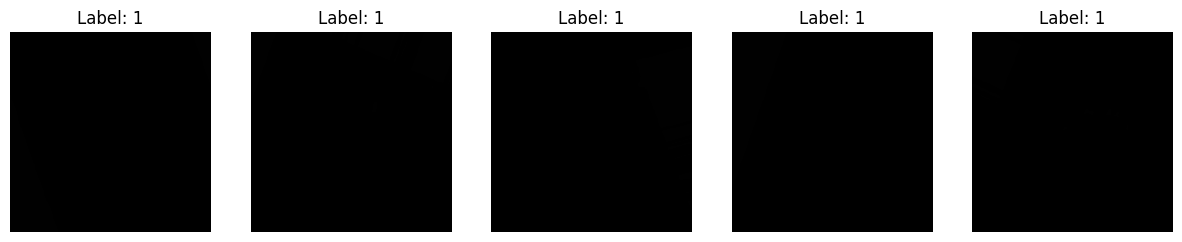

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure that X_train is in the correct format (float32) and rescale images correctly
X_train = X_train.astype("float32")

# Initialize the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Rescale images to [0, 1] range
    rotation_range=30,                  # Random rotations
    width_shift_range=0.2,              # Random horizontal shift
    height_shift_range=0.2,             # Random vertical shift
    shear_range=0.2,                    # Random shear
    zoom_range=0.2,                     # Random zoom
    horizontal_flip=True,               # Random horizontal flip
    fill_mode='nearest'                 # How to fill pixels when transforming
)

# Create the train generator
train_generator = train_datagen.flow(
    X_train, y_train_encoded,           # Input images and labels
    batch_size=32                       # Batch size
)

# Get a batch of augmented images
batch_X, batch_y = next(train_generator)  # Get one batch from the generator

# Function to plot a batch of images
def plot_images(X, y, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[i])  # Show the image
        plt.title(f"Label: {y[i]}")  # Show the label
        plt.axis('off')
    plt.show()

# Plot a few images from the augmented batch
plot_images(batch_X, batch_y, num_images=5)


In [ ]:
print(np.min(X_train), np.max(X_train))


0.0 1.0


In [ ]:
import numpy as np

# Initialize empty lists to store the data
X_train_augmented = []
y_train_augmented = []

# Iterate over the train generator to get all batches
for batch_X, batch_y in train_generator:
    X_train_augmented.append(batch_X)
    y_train_augmented.append(batch_y)

    # Break if you have processed all data (optional, depending on your data size)
    if len(X_train_augmented) * train_generator.batch_size >= len(X_train):
        break

# Convert lists to numpy arrays
X_train_augmented = np.concatenate(X_train_augmented, axis=0)
y_train_augmented = np.concatenate(y_train_augmented, axis=0)

# Now you have X_train_augmented and y_train_augmented


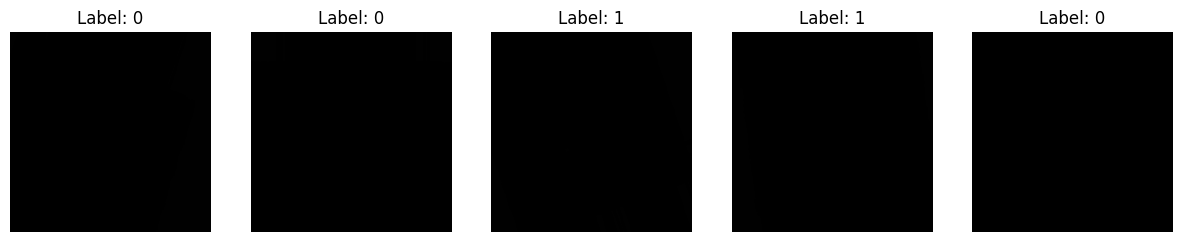

In [ ]:
import matplotlib.pyplot as plt

# Function to plot a batch of images
def plot_images(X, y, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[i])  # Show the image
        plt.title(f"Label: {y[i]}")  # Show the label
        plt.axis('off')
    plt.show()

# Plot a few images from the augmented training set
plot_images(X_train_augmented, y_train_augmented, num_images=5)


In [36]:
import random
import numpy as np
import keras
from keras import ops
import matplotlib.pyplot as plt
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

pairs_train, labels_train = make_pairs(X_train, y_train_encoded)

# make validation pairs
pairs_val, labels_val = make_pairs(X_val, y_val_encoded)

# make test pairs
pairs_test, labels_test = make_pairs(X_test, y_test_encoded)
pairs_train.shape

(2714, 2, 224, 224, 3)

In [37]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]
x_train_1.shape

(2714, 224, 224, 3)

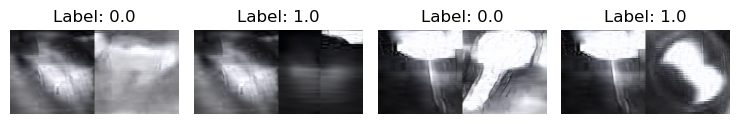

In [38]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

In [39]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

from tensorflow.keras import layers, models, regularizers

input = keras.layers.Input((224, 224, 3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(32, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(128, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="tanh")(x)
embedding_network = keras.Model(input, x)




input_1 = keras.layers.Input((224, 224, 3))
input_2 = keras.layers.Input((224, 224, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [ ]:
import random
import numpy as np
import keras
from keras import ops
import matplotlib.pyplot as plt
siamese.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_69            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_70            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_41             │ (None, 128)            │     47,565,964 │ input_layer_69[0][0],  │
│ (Functional)              │                        │                │ input_layer_70[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_22 (Lambda)        │ (None, 1)              │              0 │ functional_41[0][0],   │
│                           │                        │                │ functional_41[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 1)              │              4 │ lambda_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 1)              │              2 │ batch_normalization_6… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 47,565,970 (181.45 MB)

 Trainable params: 46,846,858 (178.71 MB)

 Non-trainable params: 719,112 (2.74 MB)

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=12,
    epochs=100,
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6181 - loss: 0.2219 - val_accuracy: 0.5215 - val_loss: 0.4194
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.6761 - loss: 0.1978 - val_accuracy: 0.5161 - val_loss: 0.4189
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.5456 - loss: 0.2624 - val_accuracy: 0.5081 - val_loss: 0.4028
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.8473 - loss: 0.1513 - val_accuracy: 0.5242 - val_loss: 0.3659
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.7985 - loss: 0.1609 - val_accuracy: 0.5511 - val_loss: 0.3449
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.6521 - loss: 0.2430 - val_accuracy: 0.5457 - val_loss: 0.3463
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.7200 - loss: 0.1823 - val_accuracy: 0.5323 - val_loss: 0.3634
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.8457 - loss: 0.1371 - val_accuracy: 0.5726 - val

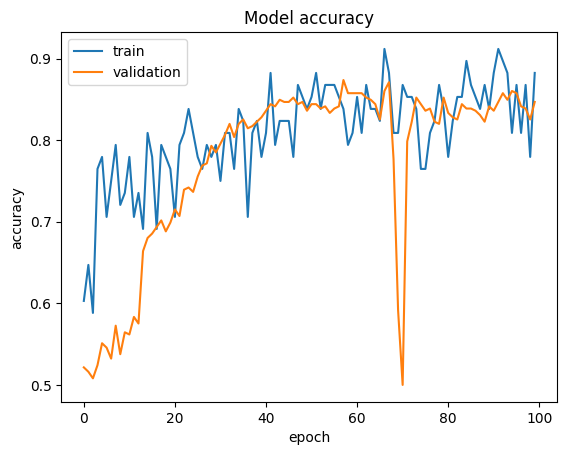

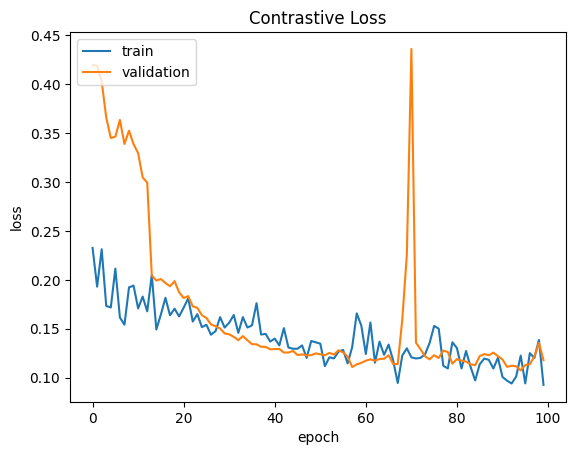

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.8770 - loss: 0.1057
test loss, test acc: [0.1115964874625206, 0.8620689511299133]


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


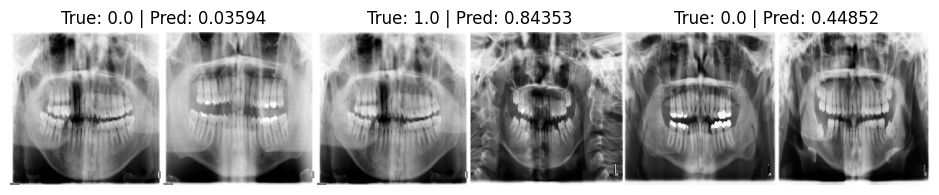

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)

In [ ]:
!pip install keras-fsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.6
    Uninstalling tensorflow-datasets-4.9.6:
      Successfully uninstalled tensorflow-datasets-4.9.6
